In [59]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px

# Load the video
video_path = "/content/output2.mp4"
cap = cv2.VideoCapture(video_path)

# Define the ROI parameters
original_size = 480
original_size2 = 640
outer_mask_radius = 220
inner_mask_radius = 65
center_x = original_size // 2
center_y = original_size2 // 2

# Create an ORB object
orb = cv2.ORB_create()

def average_distance_feature(points):
    num_points = len(points)
    distances = np.linalg.norm(np.diff(points, axis=0), axis=1)
    average_distance = np.mean(distances)
    return average_distance

def compute_center(convex_hull):
    num_points = len(convex_hull)
    centroid = np.mean(convex_hull, axis=0)
    return centroid

def average_distance_center(points, centroid):
    num_points = len(points)
    total_distance = np.sum(np.linalg.norm(points - centroid, axis=1))
    average_distance = total_distance / num_points
    return average_distance

def binary_to_decimal(binary_code):
    decimal_value = 0
    binary_code = binary_code[::-1]  # Reverse the binary code

    for i, bit in enumerate(binary_code):
        decimal_value += bit * (2**i)

    return decimal_value


def calculate_cost(descriptors, convex_hull):
    cost = []

    num_points = len(convex_hull)

    for i in range(num_points):
        current_point = convex_hull[i]
        next_point = convex_hull[(i + 1) % num_points]  # Wrap around to the first point for the last one

        current_idx = current_point[0] % len(descriptors)
        next_idx = next_point[0] % len(descriptors)

        current_desc = descriptors[current_idx]
        next_desc = descriptors[next_idx]

        distance = np.linalg.norm(current_desc - next_desc)
        cost.append(distance)

    return cost

def hull_census_transform(descriptors, convex_hull):
    binary_code = []
    num_points = len(convex_hull)

    for i in range(num_points):
        current_point = convex_hull[i]
        next_point = convex_hull[(i + 1) % num_points]  # Wrap around to the first point for the last one

        current_idx = current_point[0] % len(descriptors)
        next_idx = next_point[0] % len(descriptors)

        current_desc = descriptors[current_idx]
        next_desc = descriptors[next_idx]

        if np.linalg.norm(current_desc) > np.linalg.norm(next_desc):
            binary_code.append(1)
        else:
            binary_code.append(0)

    return binary_code

# Create an empty DataFrame to store the results
columns = ["Frame", "Convex Hull Features", "Cost of Feature Vectors", "Score Evaluation", "Color Histogram Index",
           "Average Distance of Center", "Average Distance of Feature"]
results = []

frame_number = 0
while cap.isOpened():
    if not frame_number < 20:
        break
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Create a binary mask for the ROI
    mask = np.zeros_like(frame[:, :, 0])
    rows, cols = np.indices(mask.shape)
    distance = np.sqrt((rows - center_x) ** 2 + (cols - center_y) ** 2)
    mask[(distance <= outer_mask_radius) & (distance >= inner_mask_radius)] = 1

    # Apply the mask to extract the ROI
    roi_image = cv2.bitwise_and(frame, frame, mask=mask)

    # Detect keypoints and compute descriptors
    keypoints, descriptors = orb.detectAndCompute(roi_image, None)

    # Sort keypoints based on their x-coordinate
    points = np.array([kp.pt for kp in keypoints], dtype=np.float32)
    sorted_points = sorted(points, key=lambda x: x[0])

    def orientation(p, q, r):
        return (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])

    def convex_hull(points):
        n = len(points)
        if n < 3:
            return []

        hull = []
        l = 0
        for i in range(1, n):
            if points[i][0] < points[l][0]:
                l = i

        p = l
        q = None
        while True:
            hull.append(points[p])
            q = (p + 1) % n
            for i in range(n):
                if orientation(points[p], points[i], points[q]) < 0:
                    q = i
            p = q
            if p == l:
                break

        return hull

    # Find multiple layers of convex hulls
    remaining_points = sorted_points
    convex_hull_layers = []
    num_layers = 5
    for layer in range(num_layers):
        convex_hull_points = convex_hull(remaining_points)
        if len(convex_hull_points) < 3:
            break
        convex_hull_points = np.array(convex_hull_points, dtype=np.int32)
        remaining_points = [point for point in remaining_points if point not in convex_hull_points]
        remaining_points = remaining_points[10:]
        convex_hull_layers.append(convex_hull_points)

    # Compute the binary codes
    binary_codes = []
    for layer in convex_hull_layers:
        layer_binary_code = hull_census_transform(descriptors, layer)
        binary_codes.append(layer_binary_code)

    # Compute the features of convex hulls
    feature_points = [len(layer) for layer in convex_hull_layers]

    # Compute the cost of feature vectors
    feature_costs = [calculate_cost(descriptors, layer) for layer in convex_hull_layers]

    # Compute the score evaluation (decimal values)
    decimal_values = [binary_to_decimal(binary_code) for binary_code in binary_codes]

    # Compute the color histogram index
    r_channel = roi_image[:, :, 0]
    g_channel = roi_image[:, :, 1]
    b_channel = roi_image[:, :, 2]
    wg_channel = 0.299 * r_channel + 0.587 * g_channel + 0.114 * b_channel
    hist_r = np.sum(r_channel)
    hist_g = np.sum(g_channel)
    hist_b = np.sum(b_channel)
    hist_wg = np.sum(wg_channel)
    WH = r_channel.size
    hist_r /= WH
    hist_g /= WH
    hist_b /= WH
    hist_wg /= WH
    color_histogram_index = [hist_r, hist_g, hist_b, hist_wg]

    # Compute the average distance of the center
    average_distances_center = []
    for layer in convex_hull_layers:
        centroid = compute_center(layer)
        avg_distance = average_distance_center(layer, centroid)
        average_distances_center.append(avg_distance)

    # Compute the average distance of the feature
    average_distances_feature = []
    for layer in convex_hull_layers:
        avg_distance = average_distance_feature(layer)
        average_distances_feature.append(avg_distance)

    # Create a dictionary to store the results
    result = {
        "Frame": frame_number,
        "Convex Hull Features": feature_points,
        "Cost of Feature Vectors": feature_costs,
        "Score Evaluation": decimal_values,
        "Color Histogram Index": color_histogram_index,
        "Average Distance of Center": average_distances_center,
        "Average Distance of Feature": average_distances_feature
    }

    # Append the results to the list
    results.append(result)

    frame_number += 1

cap.release()

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results, columns=columns)

# Save the results DataFrame as a CSV file
results_df.to_csv("results.csv", index=False)

In [60]:
filled_results_df = results_df.copy()
filled_results_df["Convex Hull Features"] = filled_results_df["Convex Hull Features"].apply(
    lambda x: [x[0]] * 5 if len(x) < 5 else x
)

In [61]:

# Compress parameters and filter the plot
compressed_results_df = filled_results_df.copy()
compressed_results_df["Average Distance of Center"] = compressed_results_df["Average Distance of Center"].apply(
    lambda x: np.mean(x[:4]) if len(x) > 0 else 0
)
compressed_results_df["Average Distance of Feature"] = compressed_results_df["Average Distance of Feature"].apply(
    lambda x: np.mean(x[:4]) if len(x) > 0 else 0
)

In [62]:
# Detect gradient information using a sliding window
gradient_results_df = compressed_results_df.copy()
gradient_results_df["Gradient of Average Distance of Center"] = gradient_results_df[
    "Average Distance of Center"
].diff()
gradient_results_df["Gradient of Average Distance of Feature"] = gradient_results_df[
    "Average Distance of Feature"
].diff()



In [63]:
# Generate the zero-crossing result
threshold = 0.05  # Adjust the threshold as needed
scene_change_nodes = (gradient_results_df["Gradient of Average Distance of Center"] > threshold) & (gradient_results_df["Gradient of Average Distance of Feature"] > threshold)

results_df["Scene Change Node"] = scene_change_nodes
results_df.to_csv("results4.csv", index=False)


In [75]:
# Generate the zero-crossing result
threshold = 0.05  # Adjust the threshold as needed
scene_change_nodes = gradient_results_df[
    (gradient_results_df["Gradient of Average Distance of Center"] > threshold) &
    (gradient_results_df["Gradient of Average Distance of Feature"] > threshold)
]

# Add scene change nodes to the results DataFrame
results_df["Scene Change Node"] = False
results_df.loc[scene_change_nodes.index, "Scene Change Node"] = True

# Save the results DataFrame as a CSV file
results_df.to_csv("results2.csv", index=False)

df = pd.read_csv('results2.csv')
fig = px.line(df, x = 'Frame', y = 'Scene Change Node', )
fig.show()

In [65]:
# Add scene change nodes to the results DataFrame
results_df["Scene Change Node"] = False
results_df.loc[scene_change_nodes.index, "Scene Change Node"] = True

# Save the results DataFrame as a CSV file
results_df.to_csv("results2.csv", index=False)


In [66]:
results_df

,Frame,Convex Hull Features,Cost of Feature Vectors,Score Evaluation,Color Histogram Index,Average Distance of Center,Average Distance of Feature,Scene Change Node
0,0,"[34, 31, 27, 24, 22]","[[748.3394951490934, 788.1554415215313, 734.90...","[5154354459, 104503918, 73640237, 9348277, 152...","[33.25083333333333, 45.38828776041667, 45.6027...","[218.5618760792146, 216.46398250186607, 212.54...","[40.15487641812919, 43.91234737022466, 48.6337...",False
1,1,"[37, 31, 27, 24, 23]","[[797.9122758799992, 721.4741852623696, 791.20...","[41698929342, 142355162, 42435931, 4440749, 25...","[33.416790364583335, 45.479869791666665, 45.73...","[216.17786108420583, 213.2471056906739, 205.54...","[36.86823527327568, 43.595096194997545, 49.557...",False
2,2,"[36, 30, 27, 26, 22]","[[797.1317331533102, 888.3923682697865, 934.88...","[14672434869, 20612314, 52896054, 5128810, 256...","[33.41310546875, 45.478763020833334, 45.729062...","[216.4312240368609, 210.92292114345136, 205.47...","[37.87520706442044, 45.09066585871569, 49.4042...",False
3,3,"[34, 31, 26, 24, 22]","[[805.7214158752391, 844.2055436918191, 854.41...","[7134299933, 217484012, 21975389, 10396346, 10...","[33.49552083333333, 45.55325846354167, 45.8042...","[215.28558655259093, 214.21560601341326, 204.6...","[39.06646227114516, 38.35425337559589, 50.5200...",False
4,4,"[37, 30, 24, 22, 22]","[[1065.7518472890395, 709.9415468896013, 835.6...","[40377169213, 138609558, 8663243, 274634, 549270]","[33.38682291666667, 45.560302734375, 45.720716...","[212.78313988474915, 210.87246792733086, 207.2...","[35.719493816940286, 39.43493542197737, 48.588...",False
5,5,"[36, 31, 24, 22, 24]","[[878.3006319023117, 844.7964251818304, 856.23...","[32865089173, 681904785, 5345573, 2672786, 534...","[33.554309895833335, 45.62085611979167, 45.870...","[214.1899660568091, 201.95831461476635, 202.66...","[36.79447843235304, 38.454653597656495, 49.002...",False
6,6,"[36, 29, 26, 24, 24]","[[829.2478519718939, 793.977959391821, 777.636...","[26483839660, 11482026, 37997716, 497963, 2346...","[33.65042643229167, 45.908841145833335, 46.042...","[216.54640118328064, 211.83722348435307, 204.4...","[36.75808049150746, 40.57589843231988, 44.4310...",False
7,7,"[41, 24, 21, 22, 21]","[[787.9409876380337, 690.3607752472616, 976.57...","[1747154422434, 2789969, 697384, 1394769, 692388]","[33.562666015625, 45.80875325520833, 45.982929...","[218.92980003938806, 206.62086462080183, 195.9...","[32.242874250555055, 50.0129180110728, 54.9818...",False
8,8,"[41, 25, 22, 21, 21]","[[906.8009704450035, 894.8016539993654, 807.06...","[494672141130, 17983667, 2700901, 603754, 79467]","[33.687906901041664, 45.82597330729167, 46.102...","[215.6587763869955, 215.82891258722205, 198.82...","[31.981794926667067, 47.7200642095041, 59.4826...",True
9,9,"[41, 25, 23, 20, 20]","[[684.7400966790246, 726.7365409830443, 925.98...","[595284544361, 6189148, 473645, 236822, 761110]","[33.58172526041667, 45.8359765625, 45.98009440...","[205.12241891999957, 205.7924075774056, 202.04...","[33.016077578669865, 53.437748042119274, 59.94...",False


In [67]:
import pandas as pd

# Read the CSV file
data = pd.read_csv('results2.csv')

# Calculate the average of each array column
data['Average Convex Hull'] = data['Convex Hull Features'].apply(lambda x: sum(eval(x)) / len(eval(x)))

# Convert 'Cost of Feature Vectors' column to numeric values, ignoring non-numeric elements
data['Cost of Feature Vectors'] = data['Cost of Feature Vectors'].apply(lambda x: [float(i) for i in eval(x) if isinstance(i, (int, float))])
data['Average Cost'] = data['Cost of Feature Vectors'].apply(lambda x: sum(x) / len(x) if len(x) > 0 else 0)

data['Score Evaluation'] = data['Score Evaluation'].apply(lambda x: [float(i) for i in eval(x) if isinstance(i, (int, float))])
data['Average Score Evaluation'] = data['Score Evaluation'].apply(lambda x: sum(x) / len(x) if len(x) > 0 else 0)

data['Average Color Histogram'] = data['Color Histogram Index'].apply(lambda x: sum(eval(x)) / len(eval(x)))
data['Average Distance of Center'] = data['Average Distance of Center'].apply(lambda x: sum(eval(x)) / len(eval(x)))
data['Average Distance of Feature'] = data['Average Distance of Feature'].apply(lambda x: sum(eval(x)) / len(eval(x)))

# Create a new DataFrame with the average values
result2 = data[['Frame','Average Convex Hull', 'Average Cost', 'Average Score Evaluation', 'Average Color Histogram', 'Average Distance of Center', 'Average Distance of Feature']]

# Save the new DataFrame to a CSV file
result2.to_csv('result3.csv', index=False)


In [68]:
result2

,Frame,Average Convex Hull,Average Cost,Average Score Evaluation,Average Color Histogram,Average Distance of Center,Average Distance of Feature
0,0,27.6,0,1.068675e+09,41.506386,210.698680,49.175003
1,1,28.4,0,8.378150e+09,41.633525,201.660854,48.255414
2,2,28.2,0,2.950727e+09,41.630149,200.984022,46.966561
3,3,27.4,0,1.477032e+09,41.707421,202.142862,48.065723
4,4,27.0,0,8.105053e+09,41.651640,206.644466,47.067315
5,5,27.4,0,6.712072e+09,41.771654,201.733335,47.900871
6,6,27.8,0,5.307233e+09,41.965103,204.941238,44.853186
7,7,25.8,0,3.494320e+11,41.880345,203.103218,50.318431
8,8,26.0,0,9.893870e+10,41.961246,205.552546,51.139460
9,9,25.8,0,1.190584e+11,41.896545,194.180394,52.326219


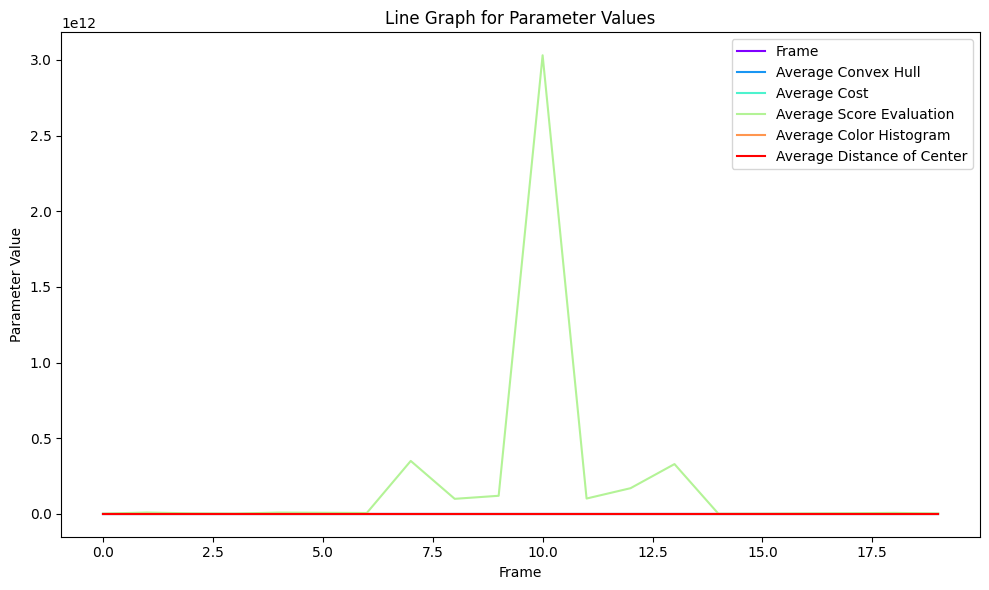

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV file
data = pd.read_csv('result3.csv')

# Extract the parameter names from the column names
parameters = data.columns[:-1]

# Set up the colors for the rainbow effect
colors = plt.cm.rainbow(np.linspace(0, 1, len(parameters)))

# Create the line graph
plt.figure(figsize=(10, 6))

for i, parameter in enumerate(parameters):
    plt.plot(data.index, data[parameter], color=colors[i], label=parameter)

# Set the labels and title
plt.xlabel('Frame')
plt.ylabel('Parameter Value')
plt.title('Line Graph for Parameter Values')

# Add a legend
plt.legend()

# Show the plot
plt.show()


In [70]:
import pandas as pd
import plotly.express as px

df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_apple_stock.csv')

fig = px.line(df, x = 'AAPL_x', y = 'AAPL_y', title='Apple Share Prices over time (2014)')
fig.show()